In [3]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.metrics import Metrics
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import CoefficientOfVariation
import numpy as np

In [4]:
## Import standard packages
from xgboost import XGBRegressor
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep

In [5]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [6]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("ticker_overview")
market.disconnect()
sic_codes = pd.read_csv("../../csv_files/sic_codes.csv").rename(columns={"SIC Code":"sic_code","Office":"office"}).dropna()
index["sic_code"] = index["sic_code"].fillna(0).astype(int)
sic_codes["sic_code"] = sic_codes["sic_code"].fillna(0).astype(int)
index = index.merge(sic_codes[["sic_code","office"]],on="sic_code")

## Retrieve previously calculated Macro Projections
fred.connect()
sp500 = p.lower_column(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
sp500 = p.utc_date(sp500)
interest_rates = p.lower_column(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates = p.utc_date(interest_rates)
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect()
macro = sp500.merge(interest_rates,on="date",how="left")
macro = p.utc_date(macro)

In [7]:
factors = ["assets","liabilities","revenue","reference_price"]

In [9]:
market.connect()
sec.connect()
factors_df = []
for row in tqdm(index.iterrows()):
    try:
        ticker = row[1]["ticker"]
        cik = int(row[1]["cik"])
        price = market.query("prices",{"ticker":ticker})
        filings = sec.query("filings",{"cik":cik})
        if price.index.size > 0 and filings.index.size > 0:
            price = p.utc_date(price)
            price = p.additional_date_columns(price)
            price.sort_values("date",inplace=True)
            price = Indicator.ROLLING_DOLLAR_VOLUME.calculate(price)
            filings = p.utc_date(filings)
            filings = p.lower_column(filings)
            filings = p.additional_date_columns(filings)
            ticker_factors = filings.drop(["date","month","week","cik"],axis=1).groupby(["year","quarter"]).mean().reset_index()
            price = price.drop(["date","ticker"],axis=1).groupby(["year","quarter"]).mean().reset_index()
            ticker_factors = ticker_factors.merge(price,on=["year","quarter"],how="left")
            ticker_factors = ticker_factors.ffill()
            ticker_factors["year"] = ticker_factors["year"] + 1
            if ticker_factors.index.size > 0:
                ticker_factors["ticker"] = ticker
                ticker_factors["reference_price"] = ticker_factors["adjclose"].shift(1)
                ticker_factors["y"] = ticker_factors["adjclose"].shift(-1)
                factors_df.append(ticker_factors[["year","quarter","ticker","adjclose","rolling_dollar_volume","y"]+factors])
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
factors_df = pd.concat(factors_df).sort_values(["year","quarter"])

4327it [02:43, 26.47it/s]


In [10]:
model_start = 2015
model_end = 2022
backtest_end = 2026
model = XGBRegressor(booster="gbtree",random_state=42)
factors_df = factors_df.dropna(subset=factors)
training_data = factors_df[(factors_df["year"]>=model_start) & (factors_df["year"]<model_end)].dropna()
sim = factors_df[(factors_df["year"]>=model_end-1) & (factors_df["year"]<backtest_end)].dropna(subset=factors)
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])
sim = sim[["ticker","year","quarter","prediction"]]

In [11]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"][::10]):
    try:
        price = p.utc_date(market.query("prices",{"ticker":ticker}))
        price = p.additional_date_columns(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price = price.merge(sim,on=["year","quarter","ticker"],how="left")
        price = p.utc_date(price)
        price = price.merge(macro,on="date",how="left")
        price["factor"] = price["prediction"] / price["adjclose"] - 1
        price = SingleIndexCAPM.apply(price)
        price = CoefficientOfVariation.apply(price)
        prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 12%|██████████████████▍                                                                                                                                       | 52/433 [00:03<00:30, 12.41it/s]

'date'


 20%|██████████████████████████████▉                                                                                                                           | 87/433 [00:06<00:27, 12.58it/s]

'date'


 59%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 257/433 [00:19<00:12, 13.92it/s]

'date'


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 433/433 [00:36<00:00, 11.99it/s]


In [12]:
sim = pd.concat(prices)
sim.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'adjclose', 'adjhigh',
       'adjlow', 'adjopen', 'adjvolume', 'divcash', 'splitfactor', 'ticker',
       'year', 'month', 'quarter', 'week', 'realtime_start', 'realtime_end',
       'rf', 'factor', 'risk', 'sigma', 'coefficient_of_variation'],
      dtype='object')

In [47]:
## getting names
simulation = pd.concat(prices).merge(index[["ticker","office","market_cap"]],on="ticker",how="left")
simulation["market_cap"] = simulation["market_cap"].astype(float)
## subsetting backtesting data
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)].dropna(subset="factor")
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]

simulation.sort_values("date", inplace=True)
simulation["sell_price"] = simulation["adjclose"]
simulation["sell_date"] = simulation["date"]

In [48]:
portfolios = PortfolioSelection.generate_possible_portfolios(group_percentages=[0.01],grouping_columns=["office"])

In [49]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [50]:
run = True
if run:
    analysises = []
    for portfolio in tqdm(portfolios):
        try:
            trades = portfolio.trades(simulation.copy(),["market_cap"])
            performance = portfolio.portfolio(trades.copy(),benchmark.copy())
            metrics = Metrics.performance(trades,performance)
            results = {**portfolio.to_dict(),**metrics.copy()}
            results["portfolio"] = portfolio
            analysises.append(results)
        except Exception as e:
            print(str(e))
            continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:39<00:00,  1.36it/s]


In [51]:
a = pd.DataFrame(analysises)

In [52]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

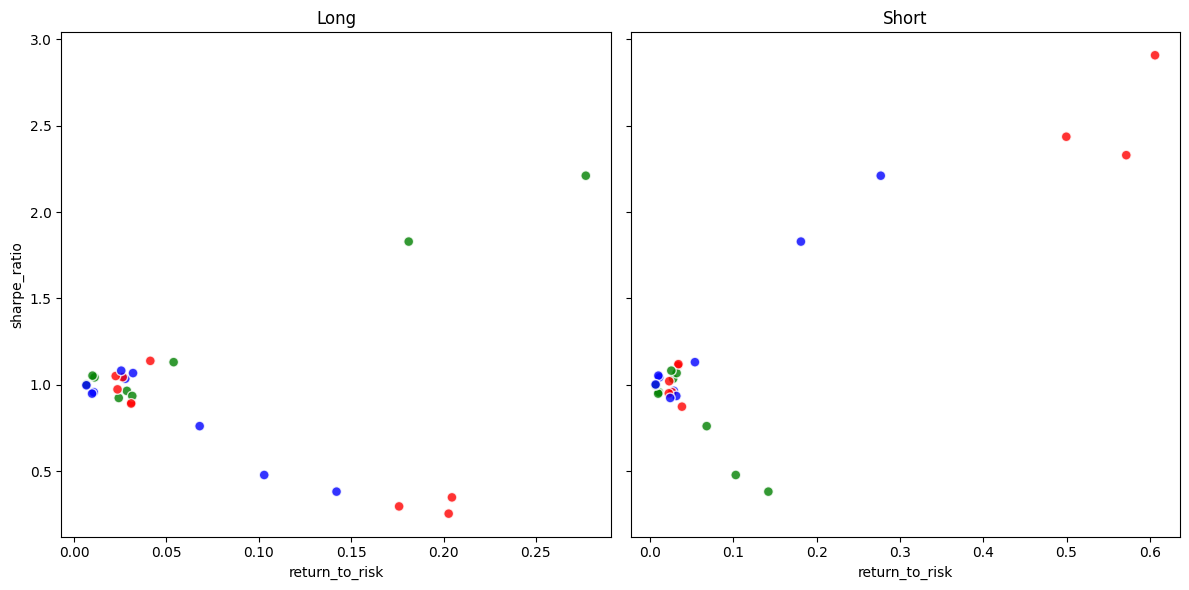

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        s=50,
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [54]:
a.groupby("pnl").first().reset_index().drop("date",axis=1).sort_values("pnl",ascending=False).head(20)

,pnl,timeframe,ranking_metric,position_type,selection_type,allocation_type,risk_type,selection_percentage,grouping_column,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,color,return_to_risk
35,2.907833,quarter,factor,short,bottom,equal,coefficient_of_variation,0.01,office,4.796497,0.606241,1.279331,0.744418,0.650350,1.092298,1.653018,<financial_common.portfolio_management.portfol...,red,4.796497
34,2.436045,month,factor,short,bottom,equal,coefficient_of_variation,0.01,office,4.874728,0.499729,1.143864,0.839715,0.615385,1.026884,1.376390,<financial_common.portfolio_management.portfol...,red,4.874728
33,2.329294,week,factor,short,bottom,equal,coefficient_of_variation,0.01,office,4.074274,0.571708,1.058788,0.937514,0.566911,1.006266,1.196300,<financial_common.portfolio_management.portfol...,red,4.074274
32,2.210384,month,factor,long,mixed,equal,coefficient_of_variation,0.01,office,7.979425,0.277010,1.132963,0.873968,0.573427,1.022482,1.668390,<financial_common.portfolio_management.portfol...,green,7.979425
31,1.828878,quarter,factor,long,mixed,equal,coefficient_of_variation,0.01,office,10.094789,0.181171,1.210371,0.735827,0.664336,1.051083,-0.424063,<financial_common.portfolio_management.portfol...,green,10.094789
30,1.138172,week,factor,long,bottom,market_cap,coefficient_of_variation,0.01,office,27.540716,0.041327,1.003500,0.997933,0.438171,1.000373,-12.272597,<financial_common.portfolio_management.portfol...,red,27.540716
29,1.130792,week,factor,long,mixed,equal,coefficient_of_variation,0.01,office,20.961365,0.053946,1.051204,0.943886,0.534161,1.001211,-9.538481,<financial_common.portfolio_management.portfol...,green,20.961365
28,1.119142,month,factor,short,bottom,risk,coefficient_of_variation,0.01,office,32.806564,0.034113,1.013193,0.986489,0.615385,1.002922,-18.440893,<financial_common.portfolio_management.portfol...,red,32.806564
27,1.110554,quarter,factor,short,bottom,risk,coefficient_of_variation,0.01,office,33.129280,0.033522,1.025399,0.976226,0.650350,1.008206,-23.720399,<financial_common.portfolio_management.portfol...,red,33.129280
26,1.081503,week,factor,short,mixed,market_cap,coefficient_of_variation,0.01,office,42.271357,0.025585,1.003347,0.997836,0.455110,1.000344,-22.038764,<financial_common.portfolio_management.portfol...,green,42.271357


In [55]:
top = a.sort_values("weekly_return",ascending=False).head(1).to_dict("records")[0]
top

{'timeframe': 'quarter',
 'ranking_metric': 'factor',
 'position_type': 'short',
 'selection_type': 'bottom',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.01,
 'grouping_column': 'office',
 'date': Timestamp('2025-03-20 00:00:00+0000', tz='UTC'),
 'pnl': 2.907832930376851,
 'coefficient_of_variation': 4.79649662839355,
 'portfolio_std': 0.6062410037283289,
 'average_gain': 1.2793312202112266,
 'average_loss': 0.7444175564941521,
 'win_loss_ratio': 0.6503496503496503,
 'weekly_return': 1.0922984706598018,
 'sharpe_ratio': 1.6530175661027353,
 'portfolio': <financial_common.portfolio_management.portfolio.Portfolio at 0x21f4603b590>,
 'color': 'red',
 'return_to_risk': 4.79649662839355}

In [56]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy(),["market_cap"]).merge(index[["ticker","office"]],on="ticker",how="left")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

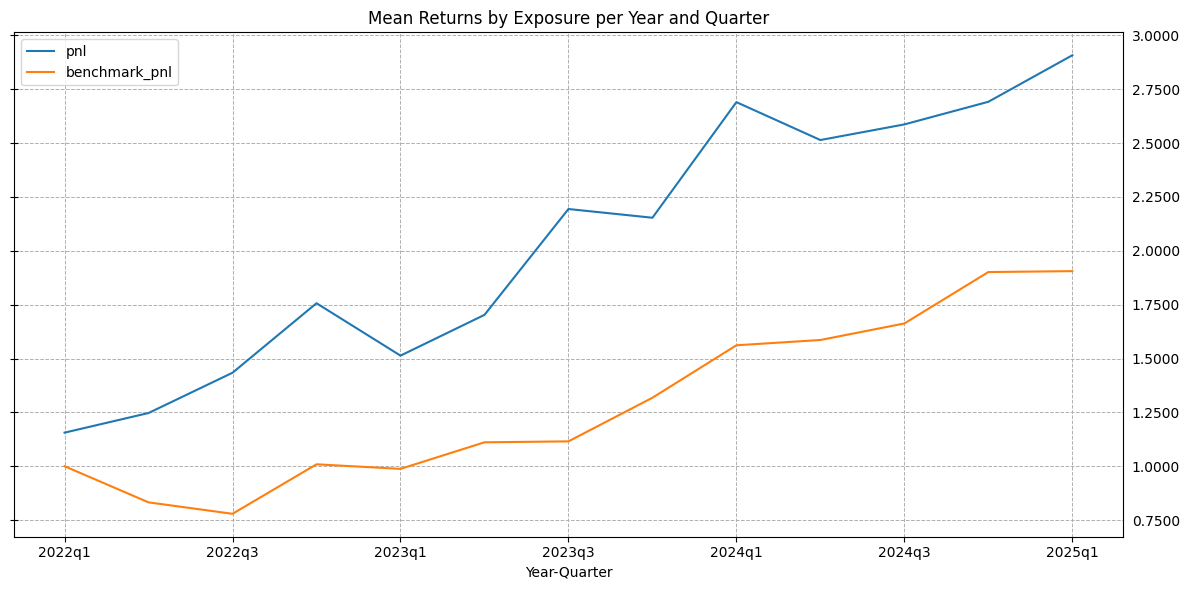

In [57]:
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
ax = portfolio[["Year-Quarter","pnl","benchmark_pnl"]].set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [58]:
portfolio.tail()

,date,return,pnl,benchmark,benchmark_pnl,year,month,quarter,week,Year-Quarter
8,2024-03-28 00:00:00+00:00,1.249166,2.690195,195.836224,1.561467,2024,3,1,13,2024q1
9,2024-06-28 00:00:00+00:00,0.934609,2.514282,198.914903,1.586014,2024,6,2,26,2024q2
10,2024-09-30 00:00:00+00:00,1.028851,2.586821,208.537174,1.662736,2024,9,3,40,2024q3
11,2024-12-31 00:00:00+00:00,1.040612,2.691876,238.472340,1.901419,2024,12,4,1,2024q4
12,2025-03-20 00:00:00+00:00,1.080225,2.907833,239.010000,1.905706,2025,3,1,12,2025q1


In [59]:
trades[["office","return"]].groupby("office").mean().sort_values("return",ascending=False).tail(20)

,return
office,
Office of Finance or Office of Crypto Assets,1.320120
Industrial Applications and Services,1.237459
Office of Technology,1.202378
Office of Manufacturing,1.173702
Office of Life Sciences,1.171452
Office of Finance,1.100078
Office of Real Estate & Construction,1.037811
Office of Crypto Assets,0.957954
Office of Energy & Transportation,0.954717
